In [10]:
# Import the necessary functions from your src package
from src.data_loader import download_and_extract_data, load_movie_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.sparse.linalg import svds

In [2]:
download_and_extract_data()

try:
    movies, ratings = load_movie_data()
    print("Data loaded successfully!")
except FileNotFoundError as e:
    print(e)

Creating directory: data
Extracting files...
Dataset downloaded and extracted successfully.
Data loaded successfully!


In [3]:
print("\nMovies DataFrame:")
display(movies.head())

print("\nRatings DataFrame:")
display(ratings.head())


Movies DataFrame:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Ratings DataFrame:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
# Calculate the number of unique users and movies
n_users = ratings['userId'].nunique()
n_movies = movies['movieId'].nunique()
n_ratings = len(ratings)

print(f"Number of unique users: {n_users}")
print(f"Number of unique movies: {n_movies}")
print(f"Total number of ratings: {n_ratings}")

Number of unique users: 610
Number of unique movies: 9742
Total number of ratings: 100836


/tmp/ipykernel_28867/3750483732.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")


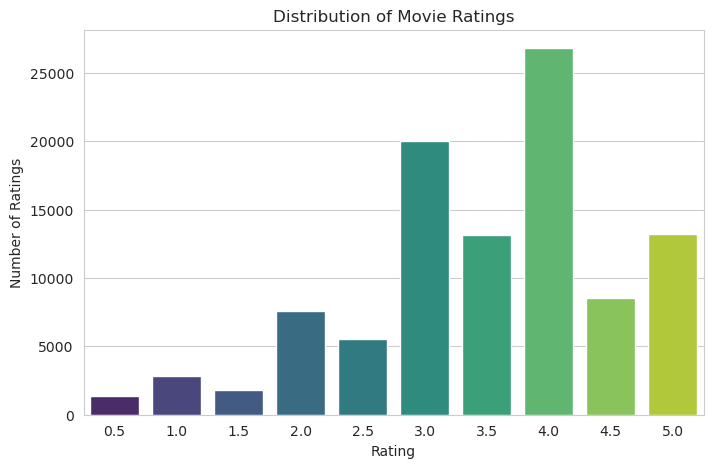

Rating Counts:


rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64

In [6]:
# Set the plot style
sns.set_style("whitegrid")

# Get the distribution of ratings
rating_counts = ratings['rating'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.show()

# Display the exact counts
print("Rating Counts:")
display(rating_counts)

In [7]:
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Group by title and count the number of ratings for each movie
most_rated_movies = movie_ratings.groupby('title')['rating'].count().sort_values(ascending=False)

print("Top 10 Most Rated Movies:")
display(most_rated_movies.head(10))

Top 10 Most Rated Movies:


title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: rating, dtype: int64

In [8]:
# Create the user-item matrix using a pivot table
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

print("Shape of the user-item matrix:", user_item_matrix.shape)
print("A snippet of the matrix:")
display(user_item_matrix.head())

Shape of the user-item matrix: (610, 9724)
A snippet of the matrix:


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Calculate the number of non-NaN values
num_ratings = user_item_matrix.count().sum()

# Calculate the total number of possible ratings
num_possible_ratings = user_item_matrix.shape[0] * user_item_matrix.shape[1]

# Calculate sparsity
sparsity = 1 - (num_ratings / num_possible_ratings)

print(f"The user-item matrix is {sparsity:.2%} sparse.")

The user-item matrix is 98.30% sparse.


In [11]:
# Fill NaN values with 0
user_item_matrix_filled = user_item_matrix.fillna(0)

# Convert to a NumPy array
R = user_item_matrix_filled.values

# Demean the data (normalize by each user's mean rating)
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

# --- Perform SVD ---
# We choose the number of latent factors (k) to find. 50 is a common choice.
k = 50
U, sigma, Vt = svds(R_demeaned, k=k)

# The sigma returned is just a list of singular values, so we make it a diagonal matrix
sigma_diag_matrix = np.diag(sigma)

# Reconstruct the original matrix with predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma_diag_matrix), Vt) + user_ratings_mean.reshape(-1, 1)

In [12]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=user_item_matrix.columns)

def recommend_movies(predictions_df, user_id, movies_df, original_ratings_df, num_recommendations=10):
    # Get the user's predicted ratings and sort them
    user_row_number = user_id - 1 # UserID starts at 1, so convert to 0-based index
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the movies the user has already rated
    user_data = original_ratings_df[original_ratings_df.userId == user_id]
    user_full = (user_data.merge(movies_df, how='left', on='movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print(f"User {user_id} has already rated {len(user_full)} movies.")

    # Recommend the highest predicted rating movies that the user has not yet seen
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how='left',
               left_on='movieId',
               right_on='movieId').
         rename(columns={user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending=False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

# --- Get recommendations for a sample user (e.g., user 13) ---
already_rated, predictions = recommend_movies(preds_df, 13, movies, ratings, 10)

print("\nTop movies already rated by User 13:")
display(already_rated.head())

print("\nTop 10 movie recommendations for User 13:")
display(predictions)

User 13 has already rated 31 movies.

Top movies already rated by User 13:


,userId,movieId,rating,timestamp,title,genres
0,13,47,5.0,987895819,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,13,1198,5.0,987456848,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
12,13,2571,5.0,987457007,"Matrix, The (1999)",Action|Sci-Fi|Thriller
29,13,4011,5.0,987895651,Snatch (2000),Comedy|Crime|Thriller
28,13,3996,5.0,987895902,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",Action|Drama|Romance



Top 10 movie recommendations for User 13:


,movieId,title,genres
3607,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
2213,2959,Fight Club (1999),Action|Crime|Drama|Thriller
223,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
894,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
1494,2028,Saving Private Ryan (1998),Action|Drama|War
4106,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
2132,2858,American Beauty (1999),Drama|Romance
1395,1923,There's Something About Mary (1998),Comedy|Romance
4769,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
906,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
